So far, I've computed the average dwell time over the period using integration, sampling, the ratio method, and the Mainsail metric. I've also computed daily averages for the integration method, for sampling, and for the ratio method and compared those to the values for the entire period.

What's next is to compute daily averages for the Mainsail metric and compare those to the values for the entire period.

Then I need to pull all of the above into a function that takes the dataframe of arrivals and departures and a sampling frequency.

Then I need to set the notebook up to ingest TOS data.

In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np

In [232]:
def dwell_times(container_times, sampling_interval):

    def plot_segments(segments, x1, x2, y1, y2, xTitle, yTitle, plotTitle, color, show):
        # Create the plot object
        for i in range(len(segments)):
            plt.plot([segments.loc[i, x1], segments.loc[i, x2]]
                      , [segments.loc[i, y1], segments.loc[i, y2]]
                     , color=color)
        
        # Display the plot
        plt.xlabel(xTitle)
        plt.ylabel(yTitle)
        plt.title(plotTitle)
        if show:
            plt.show()
        return plt

    def return_zero_for_div_by_zero(numerators, divisors):
        return [num / div if div != 0 else 0 for num, div in zip(numerators, divisors)]

    container_times['Dwell'] = container_times['Departures'] - container_times['Arrivals']
    sampling_timedelta = pd.Timedelta(hours=3)
    
    # Event list 
    event_list = pd.melt(container_times, id_vars=['Container'], value_vars=['Arrivals', 'Departures'], 
                        var_name='Event Type', value_name='Time')
    event_list = event_list.sort_values(by='Time', ascending=True)
    event_list['Box_Count_Incr'] = event_list['Event Type'].apply(lambda x: 1 if x == 'Arrivals' else -1)
    event_list['Box_Count'] = event_list['Box_Count_Incr'].cumsum()
    event_list['Next Container'] = event_list['Container'].shift(-1)
    event_list['Next Event Type'] = event_list['Event Type'].shift(-1)
    event_list['Next Event Time'] = event_list['Time'].shift(-1)
    event_list['Duration'] = event_list['Next Event Time'] - event_list['Time']

    # Intervals
    intervals = event_list.copy()
    intervals = intervals.dropna(subset=['Next Container']).copy()
    intervals['Dwell Rise'] = intervals['Duration'] * intervals['Box_Count']
    intervals = pd.merge(intervals, container_times, on='Container', how='inner')
    intervals['Dwell Loss'] = intervals.apply(lambda row: -1 * row['Dwell'] if row['Event Type'] == 'Departures' else pd.to_timedelta(0), axis=1)
    intervals['Dwell Incr'] = intervals['Dwell Rise'] + intervals['Dwell Loss']
    intervals['Ending Dwell'] = intervals['Dwell Incr'].cumsum()
    intervals['Starting Dwell'] = intervals['Ending Dwell'] - intervals['Dwell Rise']
    intervals['Starting Avg Dwell'] = intervals['Starting Dwell'] / intervals['Box_Count']
    intervals['Starting Avg Dwell'] = intervals['Starting Avg Dwell'].apply(lambda x: x.total_seconds() / 3600)
    intervals['Ending Avg Dwell'] = intervals['Ending Dwell'] / intervals['Box_Count']
    intervals['Ending Avg Dwell'] = intervals['Ending Avg Dwell'].apply(lambda x: x.total_seconds() / 3600)

    avg_dwell_segments = intervals.copy()
    avg_dwell_segments = avg_dwell_segments.drop(columns=[
                        'Container','Event Type','Box_Count_Incr','Box_Count'
                        ,'Next Container','Next Event Type','Duration','Dwell Rise'
                        ,'Arrivals','Departures','Dwell','Dwell Loss'
                        ,'Dwell Incr','Starting Dwell','Ending Dwell'])

    dwell_segments = intervals.copy()
    dwell_segments = dwell_segments.drop(columns=[
                        'Container','Event Type','Box_Count_Incr','Box_Count'
                        ,'Next Container','Next Event Type','Duration','Dwell Rise'
                        ,'Arrivals','Departures','Dwell','Dwell Loss'
                        ,'Dwell Incr','Starting Avg Dwell','Ending Avg Dwell'])
    dwell_segments['Starting Dwell Hours'] = dwell_segments['Starting Dwell'].apply(lambda x: x.total_seconds() / 3600)
    dwell_segments['Ending Dwell Hours'] = dwell_segments['Ending Dwell'].apply(lambda x: x.total_seconds() / 3600)
    dwell_segments = dwell_segments.drop(columns=['Starting Dwell', 'Ending Dwell'])

    # Total dwell time plot
    plot_segments(dwell_segments, 'Time', 'Next Event Time', 'Starting Dwell Hours', 'Ending Dwell Hours',
                  'Time (hours)', 'Total Dwell (hours)', 'Total Dwell Time Over Time', '#36454F', True)
    box_count_segments = intervals.copy()
    box_count_segments = box_count_segments.drop(columns=[
                            'Container','Event Type','Box_Count_Incr'
                            ,'Next Container','Next Event Type','Duration','Dwell Rise'
                            ,'Arrivals','Departures','Dwell','Dwell Loss'
                            ,'Dwell Incr','Ending Dwell','Starting Dwell','Starting Avg Dwell','Ending Avg Dwell'])
    
    # Box count plot
    plot_segments(box_count_segments, 'Time', 'Next Event Time', 'Box_Count', 'Box_Count',
                  'Time (hours)', 'Container Count', 'Container Count Over Time', '#36454F', True)

    sample_offset = sampling_timedelta / 2
    start_time = container_times['Arrivals'].min().normalize()
    latest_departure = container_times['Departures'].max()
    end_time = (
        latest_departure
        if latest_departure == latest_departure.normalize()
        else (latest_departure + pd.Timedelta(days=1)).normalize()
    )
    period = end_time - start_time
    sampling_times = pd.date_range(start=(start_time + sample_offset), end=end_time, freq=sampling_timedelta)
    sampling_df = pd.DataFrame(sampling_times, columns=['SamplingTime'])
    # I'm surprised that I have to do this.
    conn = sqlite3.connect(':memory:')
    sampling_df.to_sql('sampling_df', conn, index=False)
    avg_dwell_segments.to_sql('avg_dwell_segments', conn, index=False)
    query = '''
        select *
        from sampling_df samps
        left join avg_dwell_segments segs on
            samps.SamplingTime between segs.Time and segs."Next Event Time"
    '''
    sampling_df = pd.read_sql_query(query, conn)
    sampling_df['SampleDwell'] = (
        sampling_df['Starting Avg Dwell'] +
        (sampling_df['SamplingTime'].apply(pd.to_datetime) -
         sampling_df['Time'].apply(pd.to_datetime)).apply(lambda x: x.total_seconds() / 3600)
    )
    sampling_df = sampling_df.sort_values(by=['SamplingTime', 'Time'], ascending=[True, True])
    sampling_df = sampling_df.drop(columns=['Time', 'Next Event Time', 'Starting Avg Dwell', 'Ending Avg Dwell'])
    sampling_df = sampling_df.drop_duplicates(subset='SamplingTime')
    sampling_df['SampleDwell'] = sampling_df['SampleDwell'].fillna(0)

    # Avg dwell time plot
    avg_dwell_plot = plot_segments(avg_dwell_segments, 'Time', 'Next Event Time', 'Starting Avg Dwell', 'Ending Avg Dwell',
                  'Time (hours)', 'Avg Dwell (hours)', 'Avg Dwell Time Over Time and Sampled Points', '#36454F', False)
    avg_dwell_plot.scatter(sampling_df['SamplingTime'], sampling_df['SampleDwell'], color='#36454F', label='Sampling Points')
    avg_dwell_plot.show()

    # Integration result - entire period
    intervals['Avg Dwell Rise'] = intervals['Ending Avg Dwell'] - intervals['Starting Avg Dwell']
    intervals['Areas'] = intervals['Starting Avg Dwell'] * intervals['Duration'] + 0.5 * intervals['Duration'] * intervals['Avg Dwell Rise']
    #print(intervals)
    integration_result = intervals['Areas'].sum() / period

    # Sampling result - entire period
    #print(sampling_df)
    sampling_result = sampling_df['SampleDwell'].mean()

    # Ratio result - entire period
    container_times['DwellAreas'] = 0.5 * (((container_times['Departures'] - container_times['Arrivals']).apply(lambda x: x.total_seconds()/3600)) ** 2)
    container_times['BoxCountAreas'] = (container_times['Departures'] - container_times['Arrivals']).apply(lambda x: x.total_seconds()/3600)
    ratio_result = container_times['DwellAreas'].sum() / container_times['BoxCountAreas'].sum()

    # Mainsail result - entire period
    mainsail_result = (container_times['Departures'] - container_times['Arrivals']).apply(lambda x: x.total_seconds()/3600).sum()/container_times.shape[0]

    print(mainsail_result)
    """
    TODO: Finish pushing through the use of timestamps through the daily results.
    ## Daily results
    event_list_days = pd.melt(container_times, id_vars=['Container'], value_vars=['Arrivals', 'Departures'], 
                    var_name='Event Type', value_name='Time')

    last_day = end_time // 24
    first_day = start_time // 24
    num_days = last_day - first_day 
    days = list(range(first_day + 1, last_day + 1))
    new_events = pd.DataFrame({
        'Container': [None for _ in range(num_days)],
        'Event Type': ['Day Change' for _ in range(num_days)],
        'Time': [(_ + 1) * 24 for _ in range(num_days)]
    })
    
    event_list_days = pd.concat([event_list_days, new_events], ignore_index=True)
    event_list_days = event_list_days.sort_values(by=['Time', 'Event Type'], ascending=[True, False])
    event_list_days['Box_Count_Incr'] = event_list_days['Event Type'].apply(lambda x: 1 if x == 'Arrivals' else -1 if x == 'Departures' else 0)
    event_list_days['Box_Count'] = event_list_days['Box_Count_Incr'].cumsum()
    event_list_days['Next Container'] = event_list_days['Container'].shift(-1)
    event_list_days['Next Event Type'] = event_list_days['Event Type'].shift(-1)
    event_list_days['Next Event Time'] = event_list_days['Time'].shift(-1)
    event_list_days['Duration'] = event_list_days['Next Event Time'] - event_list_days['Time']
    #print('event_list_days = \n',event_list_days,'\n end event_list_days')
    
    daily_intervals = event_list_days.copy()
    daily_intervals = daily_intervals.dropna(subset=['Next Event Time']).copy()
    daily_intervals['Dwell Rise'] = daily_intervals['Duration'] * daily_intervals['Box_Count']
    trimmed_container_times = container_times[['Container', 'Dwell']]
    daily_intervals = pd.merge(daily_intervals, trimmed_container_times, on='Container', how='left')
    daily_intervals['Dwell Loss'] = daily_intervals.apply(lambda row: -1 * row['Dwell'] if row['Event Type'] == 'Departures' else 0, axis=1)
    daily_intervals['Dwell Incr'] = daily_intervals['Dwell Rise'] + daily_intervals['Dwell Loss']
    daily_intervals['Ending Dwell'] = daily_intervals['Dwell Incr'].cumsum()
    daily_intervals['Starting Dwell'] = daily_intervals['Ending Dwell'] - daily_intervals['Dwell Rise']
    daily_intervals['Starting Avg Dwell'] = return_zero_for_div_by_zero(daily_intervals['Starting Dwell'], daily_intervals['Box_Count'])
    daily_intervals['Ending Avg Dwell'] = return_zero_for_div_by_zero(daily_intervals['Ending Dwell'], daily_intervals['Box_Count'])
    daily_intervals['Avg Dwell Rise'] = daily_intervals['Ending Avg Dwell'] - daily_intervals['Starting Avg Dwell']
    daily_intervals['Areas'] = daily_intervals['Starting Avg Dwell'] * daily_intervals['Duration'] + 0.5 * daily_intervals['Duration'] * daily_intervals['Avg Dwell Rise']
    daily_intervals['Day'] = (daily_intervals['Time'] // 24) + 1
    

    # Daily integration results
    daily_integration_results = daily_intervals.groupby('Day').agg({'Areas': 'sum', 'Duration': 'sum', 'Time': 'count'}).reset_index()
    daily_integration_results = daily_integration_results.rename(columns={
        'Areas': 'Total_Areas',
        'Duration': 'Total_Duration',
        'Time': 'Record_Count'
    })
    daily_integration_results = daily_integration_results[
        ~((daily_integration_results['Total_Duration'] == 0.0) & (daily_integration_results['Record_Count'] == 1))
    ]
    daily_integration_results['avg dwell'] = daily_integration_results['Total_Areas'] / 24  
    integration_check = daily_integration_results['avg dwell'].mean()

    # Daily sampling results
    sampling_df = sampling_df.reset_index()
    sampling_df = sampling_df.drop(columns=['index'])
    sampling_df['DayIndex'] = sampling_df['SamplingTime'].apply(lambda x: int(x / 24.0) + 1)
    sampling_df['TranslatedTime'] = sampling_df['SamplingTime'] - sampling_df['DayIndex'] * 24.0
    sampling_df['TranslatedQuotient'] = sampling_df['TranslatedTime'].apply(lambda x: int(x / 24.0))
    sampling_df['Day'] = sampling_df['DayIndex'] + sampling_df['TranslatedQuotient']
    sampling_df['Day'] = sampling_df['Day'].apply(lambda x: max(x, 1))

    daily_sampling_results = sampling_df.groupby('Day')['SampleDwell'].mean().reset_index()
    daily_sampling_results = daily_sampling_results.rename(columns={
        'SampleDwell': 'Avg Dwell'
    })
    sampling_check = daily_sampling_results['Avg Dwell'].mean()

    # Daily ratio method results
    daily_ratio_results = daily_integration_results[['Day']]
    daily_ratio_results = daily_ratio_results.merge(container_times, how='cross')
    daily_ratio_results = daily_ratio_results.drop(columns=['Dwell', 'DwellAreas', 'BoxCountAreas'])
    daily_ratio_results['Start_of_day'] = (daily_ratio_results['Day'] - 1) * 24
    daily_ratio_results = daily_ratio_results[daily_ratio_results['Departures'] > daily_ratio_results['Start_of_day']]
    daily_ratio_results['End_of_day'] = daily_ratio_results['Day'] * 24
    daily_ratio_results = daily_ratio_results[daily_ratio_results['Arrivals'] < daily_ratio_results['End_of_day']]
    daily_ratio_results['Daily_dwell_start'] = np.maximum(daily_ratio_results['Arrivals'], daily_ratio_results['Start_of_day'])
    daily_ratio_results['Daily_dwell_end'] = np.minimum(daily_ratio_results['Departures'], daily_ratio_results['End_of_day'])
    daily_ratio_results['Daily_dwell_rise'] = daily_ratio_results['Daily_dwell_end'] - daily_ratio_results['Daily_dwell_start']
    daily_ratio_results['Daily_dwell_final'] = daily_ratio_results.sort_values('Day').groupby('Container')['Daily_dwell_rise'].cumsum()
    daily_ratio_results['Daily_dwell_begin'] = daily_ratio_results['Daily_dwell_final'] - daily_ratio_results['Daily_dwell_rise']
    daily_ratio_results['Daily_avg_dwell'] = (daily_ratio_results['Daily_dwell_final'] + daily_ratio_results['Daily_dwell_begin'])/2
    daily_ratio_results['Avg_dwell_term'] = daily_ratio_results['Daily_avg_dwell'] * daily_ratio_results['Daily_dwell_rise'] / 24.0
    daily_ratio_results['Avg_box_count_term'] = daily_ratio_results['Daily_dwell_rise'] / 24.0
    grouped_sum_ratio_results = daily_ratio_results.groupby('Day')[['Avg_dwell_term', 'Avg_box_count_term']].sum()
    grouped_sum_ratio_results['Division'] = grouped_sum_ratio_results['Avg_dwell_term'] / grouped_sum_ratio_results['Avg_box_count_term']
    ratio_check = grouped_sum_ratio_results['Division'].mean()

    # Mainsail metric daily results
    mainsail_daily_results = daily_integration_results.copy()
    mainsail_daily_results = mainsail_daily_results.drop(['Total_Areas', 'Total_Duration', 'Record_Count', 'avg dwell'], axis=1)
    mainsail_daily_results = mainsail_daily_results.merge(container_times, how='cross')
    mainsail_daily_results = mainsail_daily_results.drop(columns=['DwellAreas', 'BoxCountAreas'])
    mainsail_daily_results['Day_start'] = (mainsail_daily_results['Day'] - 1) * 24
    mainsail_daily_results['Day_end'] = mainsail_daily_results['Day'] * 24
    mainsail_daily_results = mainsail_daily_results[(mainsail_daily_results['Arrivals'] >= mainsail_daily_results['Day_start']) & (mainsail_daily_results['Departures'] <= mainsail_daily_results['Day_end'])]
    grouped_ms_daily_results = mainsail_daily_results.groupby('Day')['Dwell'].mean().reset_index()
    grouped_ms_daily_results = grouped_ms_daily_results.rename(columns={'Dwell': 'AvgDwell'})
    days_df = grouped_sum_ratio_results.copy()
    days_df = days_df.drop(columns=['Avg_dwell_term', 'Avg_box_count_term', 'Division'])
    mainsail_daily_results = days_df.merge(grouped_ms_daily_results, on='Day', how='left')
    mainsail_daily_results['AvgDwell'] = mainsail_daily_results['AvgDwell'].fillna(0)
    mainsail_check = mainsail_daily_results['AvgDwell'].mean()
    
    return (integration_result, daily_integration_results, integration_check, 
            sampling_result, daily_sampling_results, sampling_check, 
            ratio_result, grouped_sum_ratio_results, ratio_check,
            mainsail_result, mainsail_daily_results, mainsail_check)
    """

In [233]:
data = {
    'Container': ['A', 'B', 'C'],
    'Arrivals': [pd.Timestamp('2024-09-01 00:00:00'), pd.Timestamp('2024-09-01 12:00:00'), pd.Timestamp('2024-09-02 00:00:00')],
    'Departures': [pd.Timestamp('2024-09-02 12:00:00'), pd.Timestamp('2024-09-03 00:00:00'), pd.Timestamp('2024-09-04 00:00:00')]
}

box_schedules = pd.DataFrame(data)
print(box_schedules)

  Container            Arrivals          Departures
0         A 2024-09-01 00:00:00 2024-09-02 12:00:00
1         B 2024-09-01 12:00:00 2024-09-03 00:00:00
2         C 2024-09-02 00:00:00 2024-09-04 00:00:00


In [234]:
sample_gap = 3

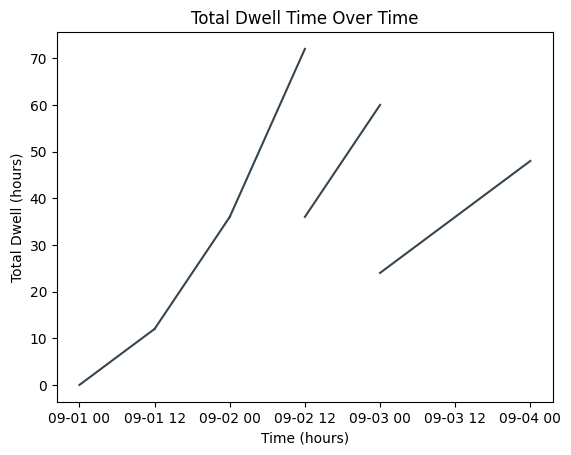

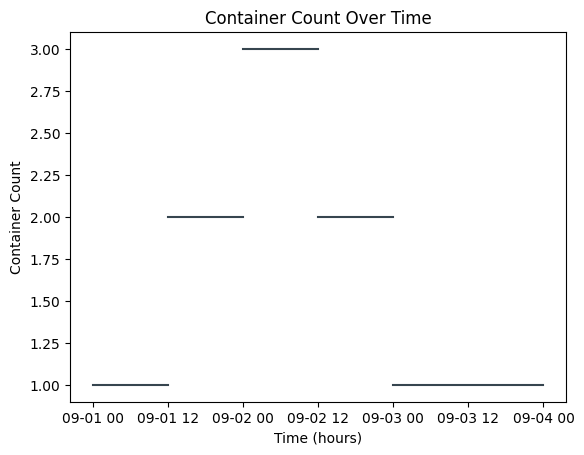

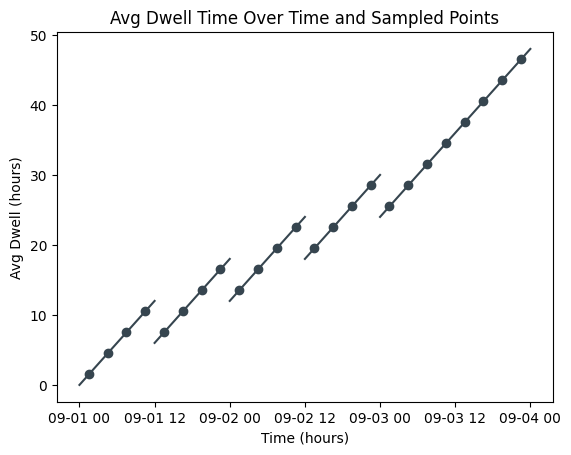

  Container            Arrivals          Departures           Dwell  \
0         A 2024-09-01 00:00:00 2024-09-02 12:00:00 1 days 12:00:00   
1         B 2024-09-01 12:00:00 2024-09-03 00:00:00 1 days 12:00:00   
2         C 2024-09-02 00:00:00 2024-09-04 00:00:00 2 days 00:00:00   

   DwellAreas  BoxCountAreas  
0       648.0           36.0  
1       648.0           36.0  
2      1152.0           48.0  
40.0


In [235]:
dwell_times(box_schedules, sample_gap)